![head.png](https://github.com/cafawo/FinancialDataAnalytics/blob/master/figures/head.jpg?raw=1)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

# Homework: Value at Risk

You will need a Git/GitHub repository to submit your course deliverables. Consult [**slides.ipynb**](https://github.com/cafawo/FinancialDataAnalytics) for help with the tasks below! If you need further assistance, do not hesitate to open a Q&A at https://github.com/cafawo/FinancialDataAnalytics/discussions

In this assignment you will work with data that is stored in a file named **02_python_data.csv**, which contains daily stock prices for various companies listed on Deutsche Börse (Xetra). The columns are labeled with Reuters identifier code (RIC). The first RIC '.GDAXI' is the german DAX index, the remaining RICs represent its constituents.

### Task: 

Load the data and show in a single plot the cumulative log-returns of '.GDAXI' as well as an equally weighted portfolio of its constituents (all the other assets in 02_python_data.csv, excluding '.GDAXI').

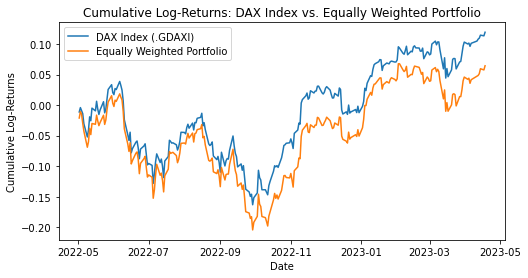

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read data from CSV file
prices = pd.read_csv('02_python_data.csv', index_col=0, parse_dates=True)
returns = prices.pct_change()
logreturns = np.log(prices) - np.log(prices.shift(1))

# DAX:
cumulative_logreturns_gdaxi = logreturns['.GDAXI'].cumsum()

# Portfolio:
logreturns_constituents = logreturns.drop(columns=['.GDAXI'])
# Equally weighted
weights = np.ones(len(logreturns_constituents.columns)) / len(logreturns_constituents.columns)
logreturns_portfolio = logreturns_constituents.dot(weights)
cumulative_logreturns_portfolio = logreturns_portfolio.cumsum()

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(cumulative_logreturns_gdaxi, label='DAX Index (.GDAXI)')
plt.plot(cumulative_logreturns_portfolio, label='Equally Weighted Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Log-Returns')
plt.legend()
plt.title('Cumulative Log-Returns: DAX Index vs. Equally Weighted Portfolio')
plt.show()

### Task: 

We now want to compare the risk of **both** portfolios from the previous task ('.GDAXI and the equally weighted portfolio'). To do so, calculate the 95% 1-day [Value at Risk (VaR)](https://en.wikipedia.org/wiki/Value_at_risk), using:

* Historical simulation,
* the Parametric method,
* Monte Carlo simulation.

Add all values to a data frame and `display()`

In [5]:
from scipy.stats import norm

# Historical simulation:
historical_var_gdaxi = -logreturns['.GDAXI'].quantile(1 - 0.95)
historical_var_portfolio = -logreturns_portfolio.quantile(1 - 0.95)

# Parametric method (using normal distribution):
std_gdaxi = logreturns['.GDAXI'].std()
# For very short time horizons (e.g. 1 day) it can be reasonable to assume mu = 0
parametric_var_gdaxi = -norm.ppf(1 - 0.95) * std_gdaxi
std_portfolio = logreturns_portfolio.std()
parametric_var_portfolio = -norm.ppf(1 - 0.95) * std_portfolio

# Monte Carlo simulation
n_simulations = 10000
time_horizon = 1

simulated_returns_gdaxi = np.random.normal(0, std_gdaxi * np.sqrt(time_horizon), n_simulations)
simulated_returns_portfolio = np.random.normal(0, std_portfolio * np.sqrt(time_horizon), n_simulations)
monte_carlo_var_gdaxi = -np.percentile(simulated_returns_gdaxi, 100 * (1 - 0.95))
monte_carlo_var_portfolio = -np.percentile(simulated_returns_portfolio, 100 * (1 - 0.95))

# Display in table format
var_df = pd.DataFrame({'DAX Index (.GDAXI)': [historical_var_gdaxi, parametric_var_gdaxi, monte_carlo_var_gdaxi],
                       'Equally Weighted Portfolio': [historical_var_portfolio, parametric_var_portfolio, monte_carlo_var_portfolio]},
                      index=['Historical Simulation', 'Parametric', 'Monte Carlo'])

display(var_df)

,DAX Index (.GDAXI),Equally Weighted Portfolio
Historical Simulation,0.019456,0.021996
Parametric,0.019895,0.021166
Monte Carlo,0.019800,0.020832


### Task: 

In order to visualize the VaR results we focus only on '.GDAXI' (you can create `plt.subplots()` for the equally weighted portfolio if you like). In the plot:

1. Plot a histogram of the returns
2. Add a line plot of the normal distribution (parameterized to the returns)
3. Add indicators for the 3 VaRs (vertical lines or annotations)

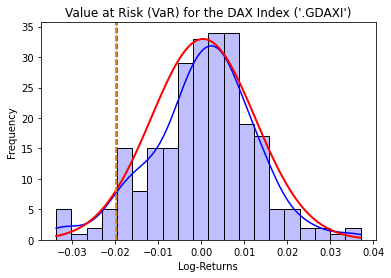

In [6]:
import seaborn as sns

# Plot histogram of the returns
sns.histplot(logreturns['.GDAXI'].dropna(), kde=True, bins=20, color='blue', alpha=0.25, label='Returns')

# Add line plot of the normal distribution pdf
x = np.linspace(logreturns['.GDAXI'].min(), logreturns['.GDAXI'].max(), 100)
pdf = norm.pdf(x, logreturns['.GDAXI'].mean(), logreturns['.GDAXI'].std())
plt.plot(x, pdf, 'r', linewidth=2, label='Normal Distribution')

# Add indicators for the 3 VaRs
plt.axvline(x=-historical_var_gdaxi, color='g', linestyle='--', label=f'Historical VaR (95%): {historical_var_gdaxi:.4f}')
plt.axvline(x=-parametric_var_gdaxi, color='purple', linestyle='--', label=f'Parametric VaR (95%): {parametric_var_gdaxi:.4f}')
plt.axvline(x=-monte_carlo_var_gdaxi, color='orange', linestyle='--', label=f'Monte Carlo VaR (95%): {monte_carlo_var_gdaxi:.4f}')

# Customize plot
#plt.legend()
plt.title("Value at Risk (VaR) for the DAX Index ('.GDAXI')")
plt.xlabel("Log-Returns")
plt.ylabel("Frequency")
plt.show()